# XGBoost & LightGBM 실습
* 이수안 컴퓨터 연구소 영상의 노트북 필사입니다.
* 링크: https://www.youtube.com/watch?v=4Jz4_IOgS4c&list=PL7ZVZgsnLwEEd3-h-jySLz4wT154r7VVr&index=10

## XGBoost
* 트리 기반의 앙상블 기법
* 분류에 있어서 다른 알고리즘보다 좋은 예측 성능을 보여줌
* XGBoost는 GBM 기반이지만, GBM의 단점인 느린 수행시간과 과적합 규제 부재 등의 문제를 해결
* 병렬 CPU 환경에서 빠르게 학습 가능

### 파이썬 기반 XGBoost

In [179]:
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.datasets import load_boston, load_diabetes
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance, plot_tree

import graphviz
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])

In [180]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=123)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [181]:
params = {
  'max_depth': 3,
  'eta': 0.1,
  'objective' : 'binary:logistic',
  'eval_metric': 'logloss',
  'early_stopping': 100
}
num_rounds = 400

In [182]:
evals = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, 
                      early_stopping_rounds=100, evals=evals)

[16:16:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.60944	eval-logloss:0.61010
[1]	train-logloss:0.54047	eval-logloss:0.54074
[2]	train-logloss:0.48211	eval-logloss:0.48490
[3]	train-logloss:0.43365	eval-logloss:0.43922
[4]	train-logloss:0.39072	eval-logloss:0.39791
[5]	train-logloss:0.35372	eval-logloss:0.36211
[6]	train-logloss:0.32222	eval-logloss:0.32996
[7]	train-logloss:0.29292	eval-logloss:0.30179
[8]	train-logloss:0.26731	eval-logloss:0.27801
[9]	train-logloss:0.24409	eval-logloss:0.25775
[10]	train-logloss:0.22517	eval-logloss:0.24037
[11]	trai

In [183]:
import numpy as np
predicts = xgb_model.predict(dtest)
print(np.round(predicts[:10], 3))

[1.    0.999 0.001 0.995 0.001 0.989 0.995 0.998 0.966 0.795]


In [184]:
preds = [1 if x > 0.5 else 0 for x in predicts]
print(preds[:10])

[1, 1, 0, 1, 0, 1, 1, 1, 1, 1]


In [185]:
print("정확도: {}".format(accuracy_score(y_test, preds)))
print("정밀도: {}".format(precision_score(y_test, preds)))
print("재현율: {}".format(recall_score(y_test, preds)))

정확도: 0.9736842105263158
정밀도: 0.972972972972973
재현율: 0.9863013698630136


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

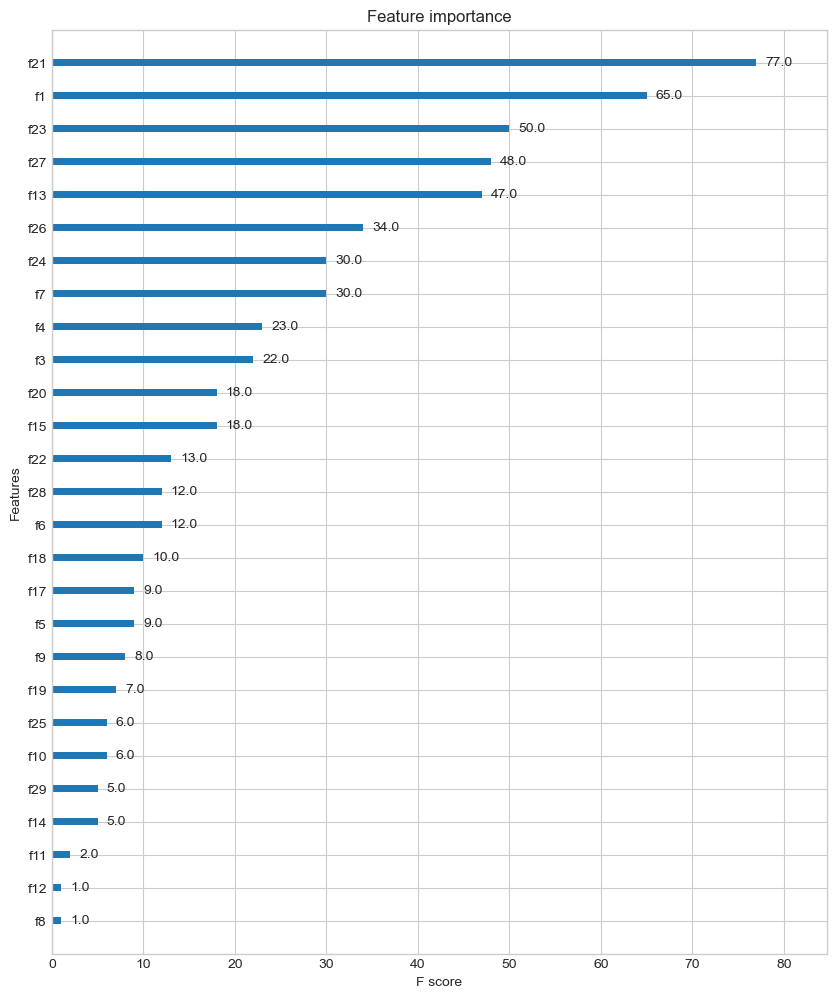

In [186]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

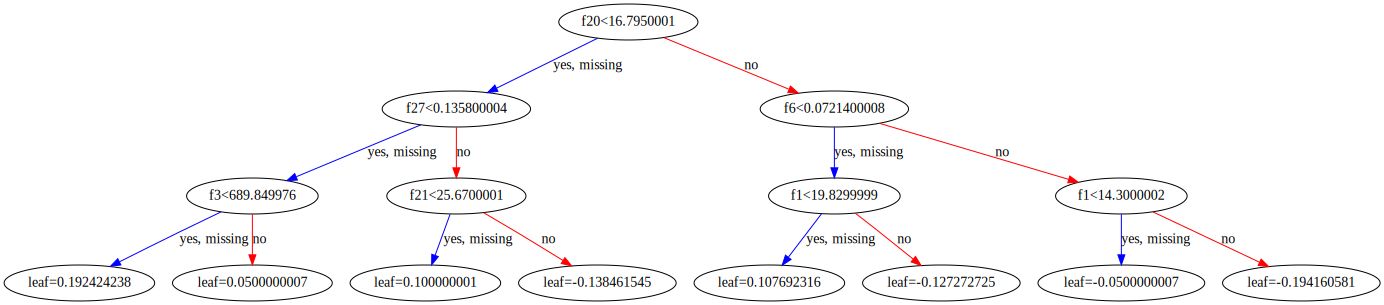

In [187]:
dot_data = xgb.to_graphviz(xgb_model)
dot_data

# graph = graphviz.Source(dot_data) 했을 때 오히려 오류 발생

### XGBClassifier

In [188]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=123)

In [189]:
xgbc = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgbc.fit(X_train, y_train)

preds = xgbc.predict(X_test)
preds_proba = xgbc.predict_proba(X_test)[:, 1]

/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [190]:
cross_val = cross_validate(
  estimator=xgbc,
  X=iris.data, y=iris.target,
  cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
avg fit time: 0.3876059055328369 (+/- 0.04592586824216955)
avg score time: 0.0020363330841064453 (+/- 0.0002612409717685519)
avg test score: 0.96 (+/- 0.024944382578492935)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

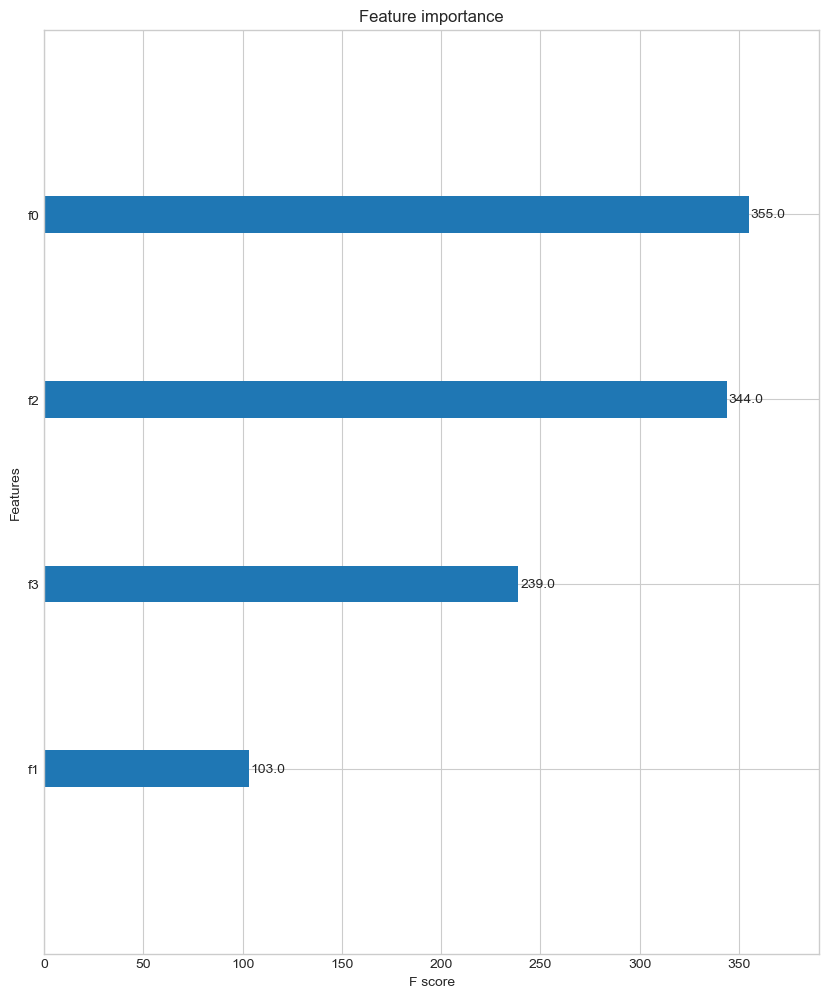

In [191]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgbc, ax=ax)

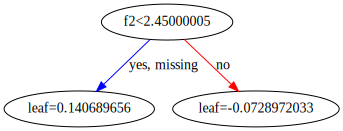

In [192]:
dot_data = xgb.to_graphviz(xgbc)
dot_data

### 와인 데이터

In [193]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.2, random_state=123)

In [194]:
xgbc = XGBClassifier(n_estimators =400, learning_rate=0.1, max_depth=3)
xgbc.fit(X_train, y_train)
preds = xgbc.predict(X_test)

/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [195]:
cross_val = cross_validate(
  estimator=xgbc,
  X=wine.data, y=wine.target,
  cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
avg fit time: 0.2841674327850342 (+/- 0.024798550792318796)
avg score time: 0.0016473770141601563 (+/- 6.60416193379039e-05)
avg test score: 0.9609523809523809 (+/- 0.028267341226138717)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

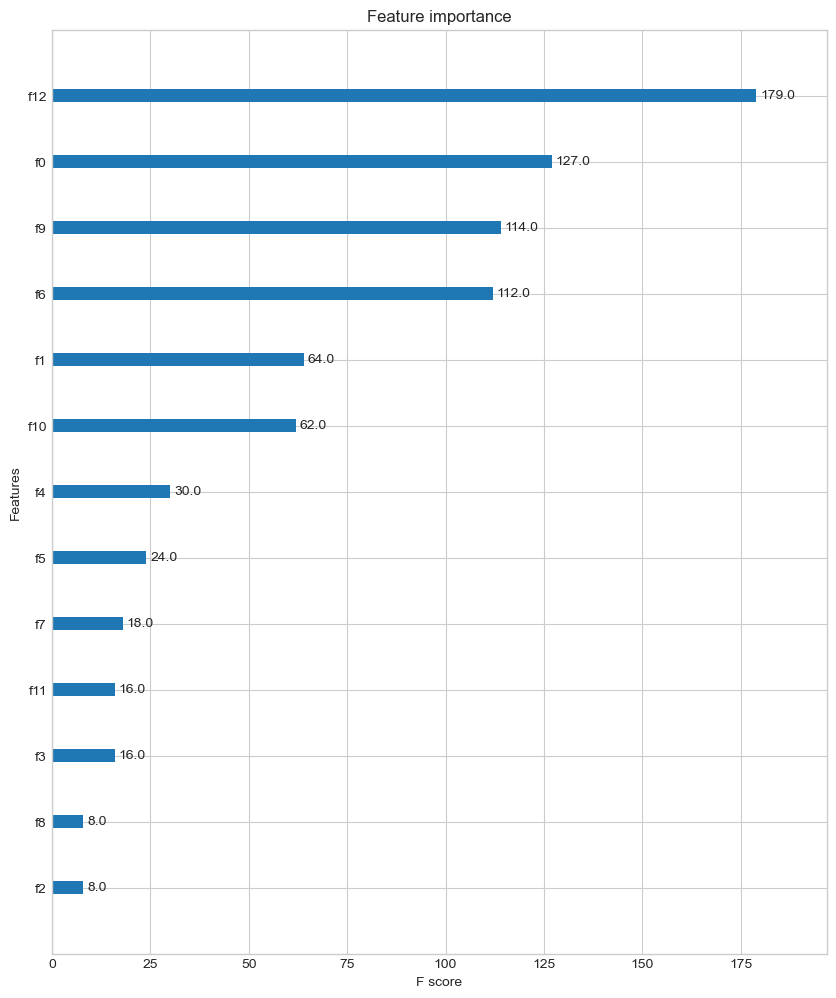

In [196]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgbc, ax=ax)

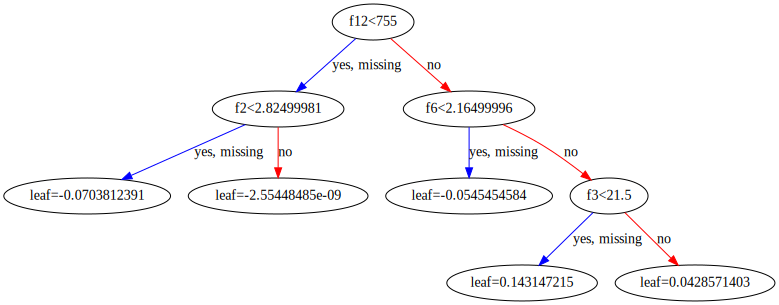

In [197]:
dot_data = xgb.to_graphviz(xgbc)
dot_data

### 유방암 데이터

In [198]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=123)

In [199]:
xgbc = XGBClassifier(n_estimators =400, learning_rate=0.1, max_depth=3)
xgbc.fit(X_train, y_train)
preds = xgbc.predict(X_test)

/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [200]:
cross_val = cross_validate(
  estimator=xgbc,
  X=cancer.data, y=cancer.target,
  cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
avg fit time: 0.21753320693969727 (+/- 0.020122018410795497)
avg score time: 0.001959371566772461 (+/- 0.00012613702963915795)
avg test score: 0.9736376339077782 (+/- 0.009609619188189153)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

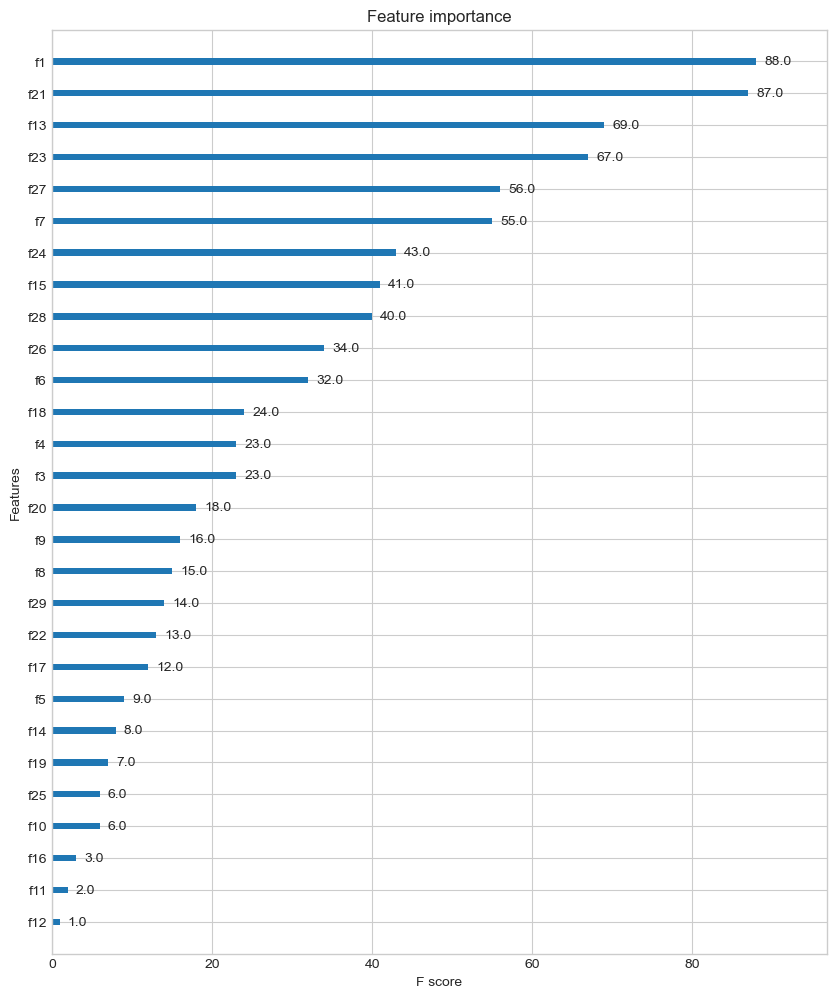

In [201]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgbc, ax=ax)

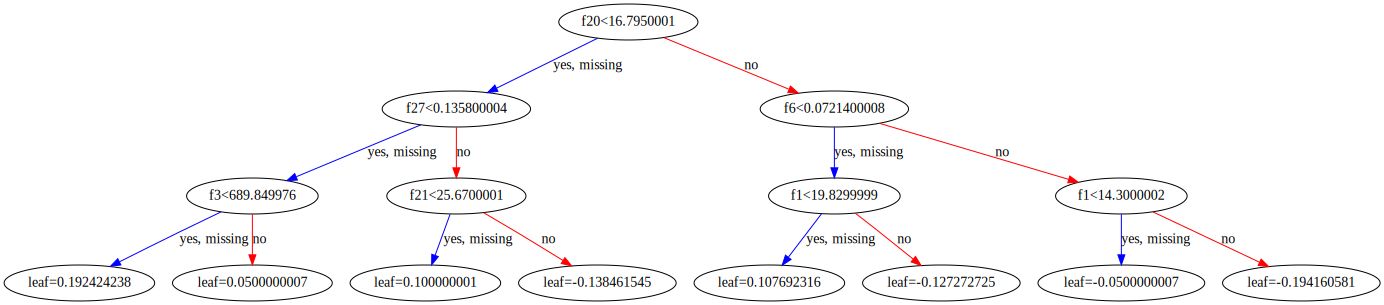

In [202]:
dot_data = xgb.to_graphviz(xgbc)
dot_data

## XGBRegressor
* 분류에 특화된 모델이지만, 회귀도 가능하다.

In [203]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=123)

In [204]:
xgbr = XGBRegressor(n_estimators =400, learning_rate=0.1, max_depth=3)
xgbr.fit(X_train, y_train)
preds = xgbr.predict(X_test)

In [205]:
cross_val = cross_validate(
  estimator=xgbc,
  X=cancer.data, y=cancer.target,
  cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jihye/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
avg fit time: 0.22168412208557128 (+/- 0.019725222357942933)
avg score time: 0.0019083023071289062 (+/- 0.0002334445904993577)
avg test score: 0.9736376339077782 (+/- 0.009609619188189153)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

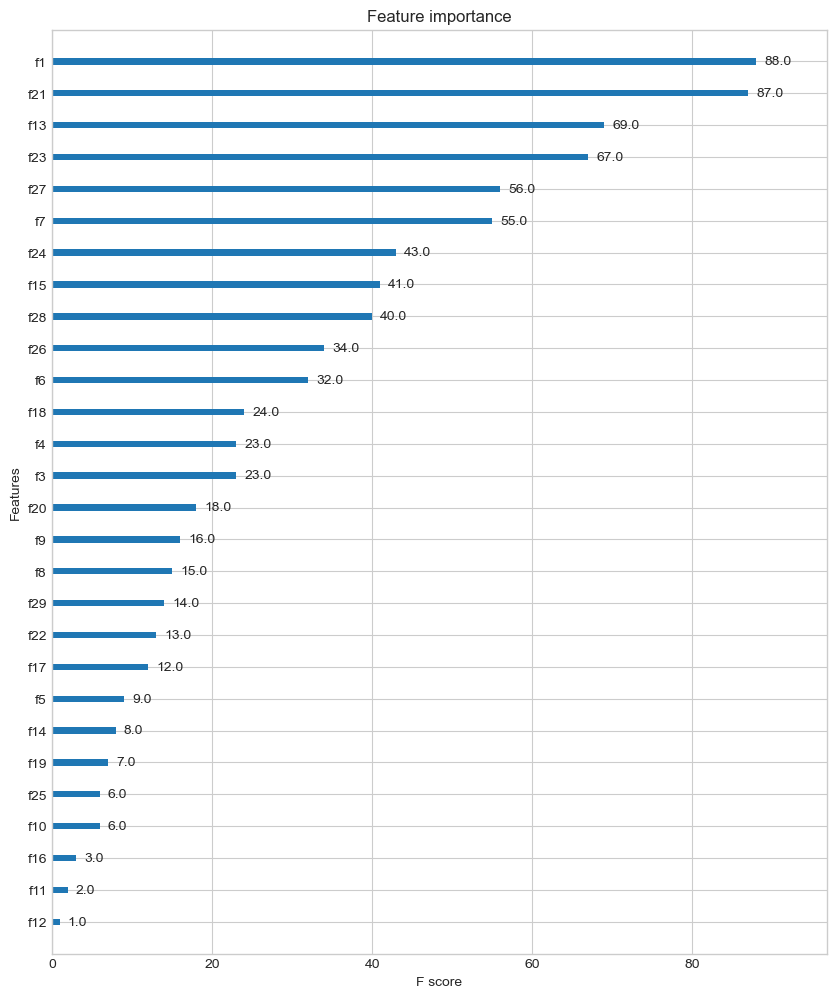

In [206]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgbc, ax=ax)

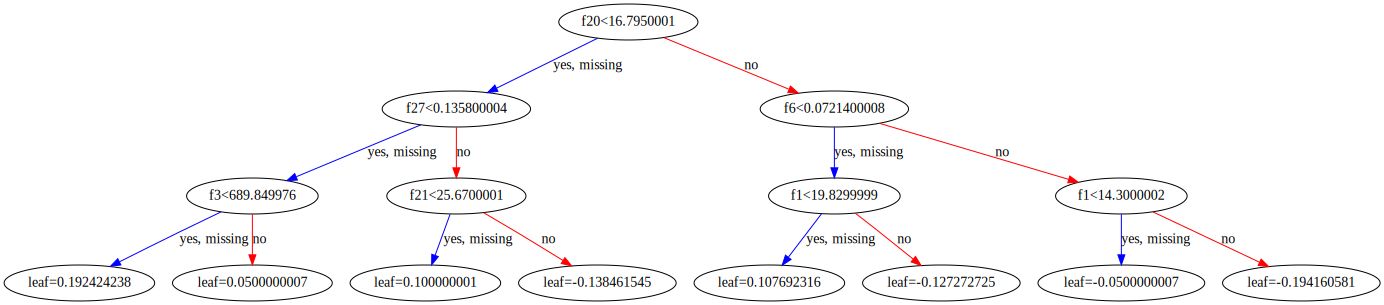

In [207]:
dot_data = xgb.to_graphviz(xgbc)
dot_data

### 당뇨병 데이터

In [208]:
diabetes = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, test_size=0.2, random_state=123)

In [210]:
xgbr = XGBRegressor(n_estimators =400, learning_rate=0.1, max_depth=3)
xgbr.fit(X_train, y_train)
preds = xgbr.predict(X_test)

In [ ]:
cross_val = cross_validate(
  estimator=xgbc,
  X=diabetes.data, y=diabetes.target,
  cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

avg fit time: 0.27301583290100095 (+/- 0.028312170521201604)
avg score time: 0.00195460319519043 (+/- 0.0003926607469698026)
avg test score: 0.2998837790950602 (+/- 0.07527155614299372)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

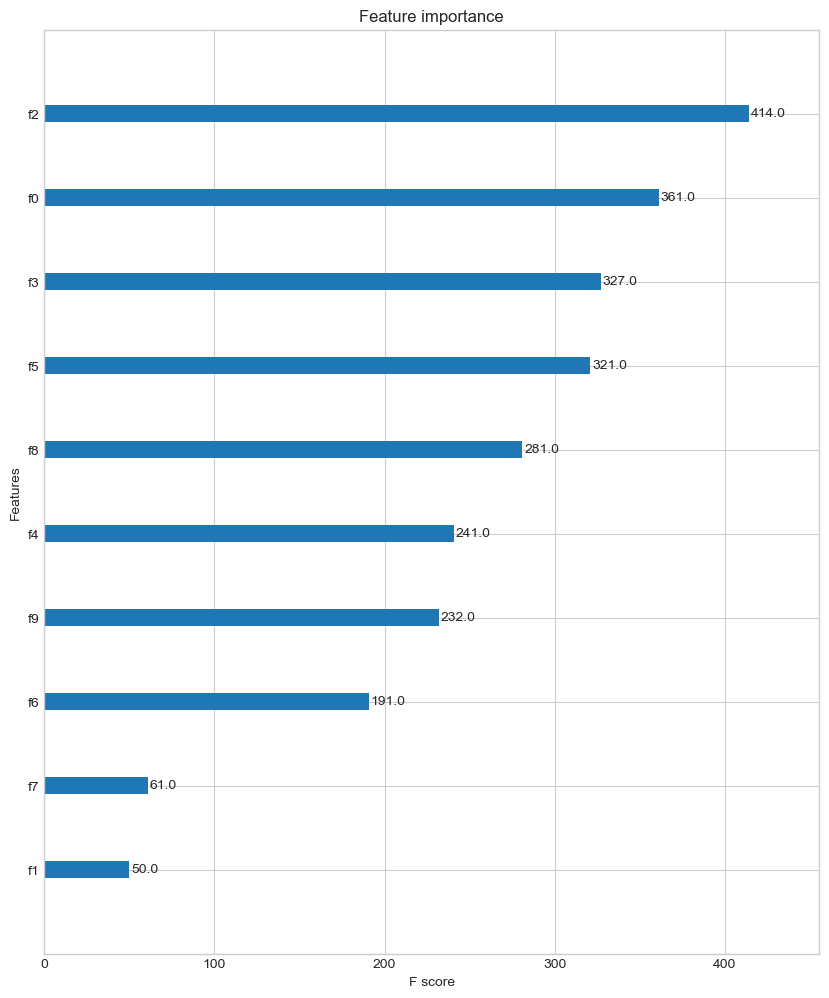

In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgbc, ax=ax)

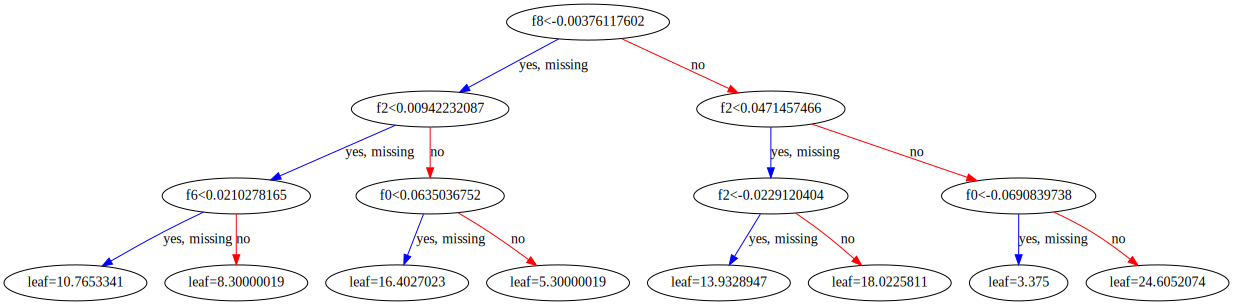

In [ ]:
dot_data = xgb.to_graphviz(xgbc)
dot_data

## LightGBM
* 빠른 학습과 예측시간
* 더 적은 메모리 사용
* 범주형 특징의 자동 변환과 최적 분할

### LightGBM 라이브러리 설치

In [248]:
import lightgbm as lgbm
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm import plot_importance, plot_metric, plot_tree

### 붓꽃 데이터

In [ ]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=123)

In [ ]:
lgbmc = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]
lgbmc.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbmc.predict(X_test)

[1]	valid_0's multi_logloss: 0.95847
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.832184
[3]	valid_0's multi_logloss: 0.731164
[4]	valid_0's multi_logloss: 0.641056
[5]	valid_0's multi_logloss: 0.571726
[6]	valid_0's multi_logloss: 0.507286
[7]	valid_0's multi_logloss: 0.454933
[8]	valid_0's multi_logloss: 0.410205
[9]	valid_0's multi_logloss: 0.372194
[10]	valid_0's multi_logloss: 0.333919
[11]	valid_0's multi_logloss: 0.310212
[12]	valid_0's multi_logloss: 0.282326
[13]	valid_0's multi_logloss: 0.257165
[14]	valid_0's multi_logloss: 0.240836
[15]	valid_0's multi_logloss: 0.225383
[16]	valid_0's multi_logloss: 0.211583
[17]	valid_0's multi_logloss: 0.199289
[18]	valid_0's multi_logloss: 0.186269
[19]	valid_0's multi_logloss: 0.171556
[20]	valid_0's multi_logloss: 0.168245
[21]	valid_0's multi_logloss: 0.161065
[22]	valid_0's multi_logloss: 0.151371
[23]	valid_0's multi_logloss: 0.148081
[24]	valid_0's multi_logloss: 0.143843
[25]	valid_0

In [ ]:
cross_val = cross_validate(
  estimator=lgbmc,
  X=iris.data, y=iris.target,
  cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

avg fit time: 0.48856472969055176 (+/- 0.22857809650137326)
avg score time: 0.0015294075012207032 (+/- 0.0008592095052939989)
avg test score: 0.9600000000000002 (+/- 0.04898979485566355)


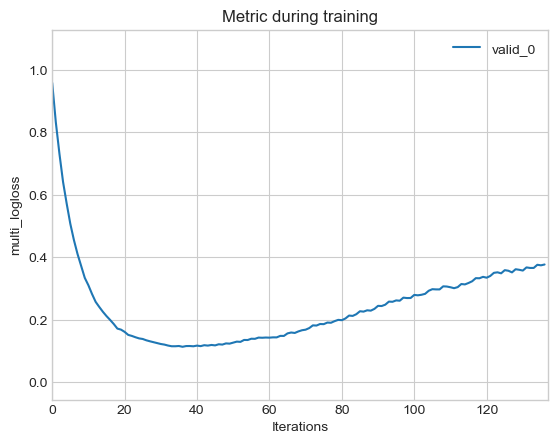

In [ ]:
plot_metric(lgbmc);

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

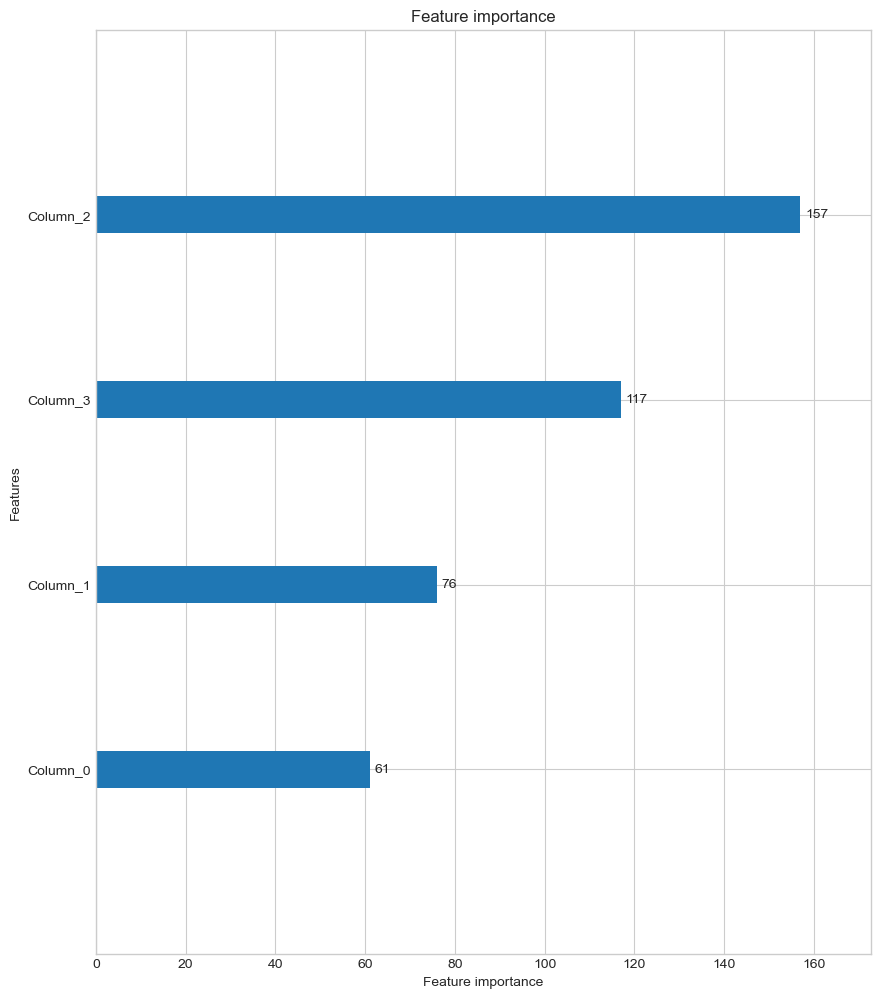

In [ ]:
plot_importance(lgbmc, figsize=(10, 12))

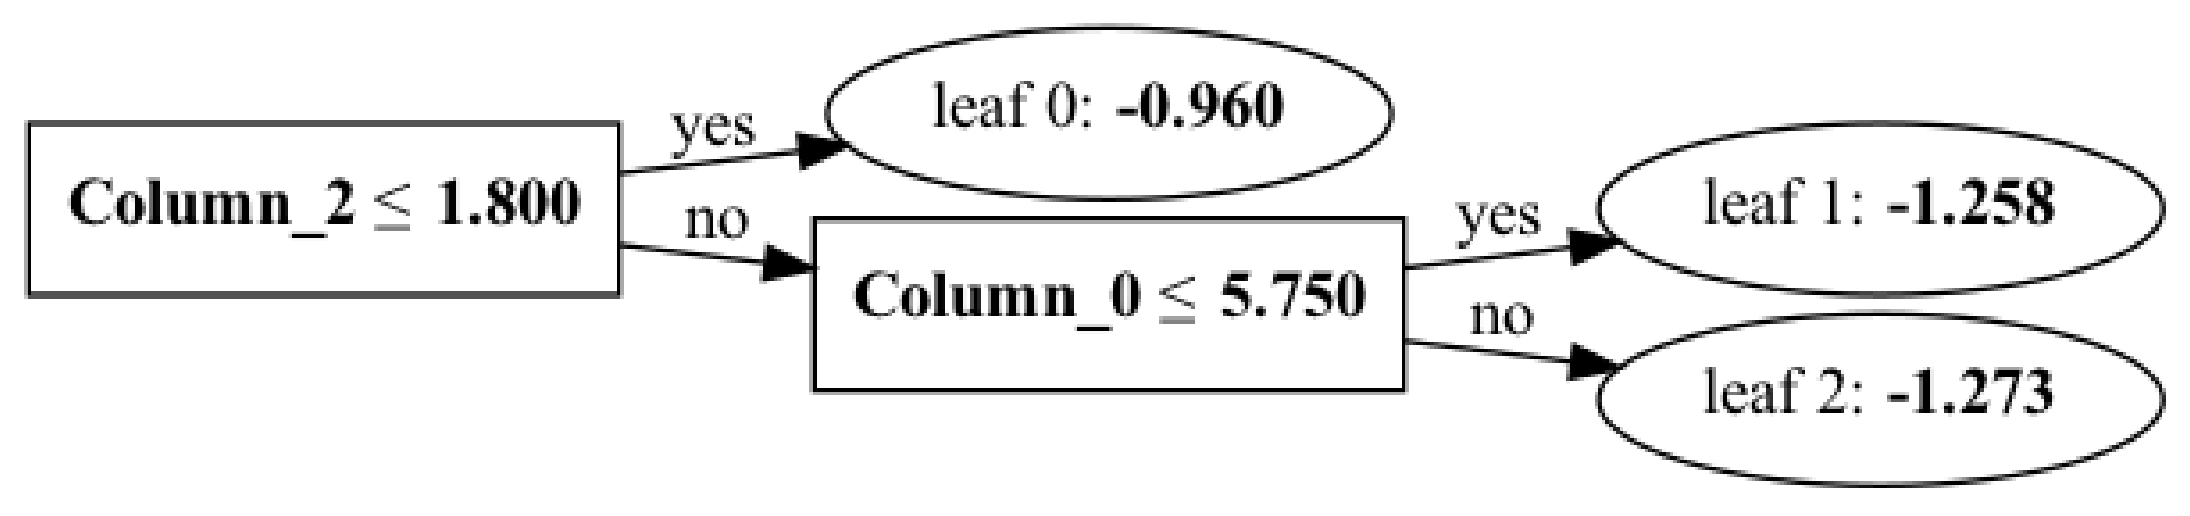

In [ ]:
# lightgbm은 balanced 보다는 skewness가 높아지더라도 최적화에 집중하는 경향을 갖는다.

plot_tree(lgbmc, figsize=(28, 24));

### LIghtRegressor

#### 와인 데이터

In [237]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.2, random_state=123)

In [238]:
lgbmr = LGBMRegressor(n_estimators=400)
evals = [(X_test, y_test)]
lgbmr.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbmr.predict(X_test)

[1]	valid_0's l2: 0.654424
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.550474
[3]	valid_0's l2: 0.462007
[4]	valid_0's l2: 0.391693
[5]	valid_0's l2: 0.331632
[6]	valid_0's l2: 0.289121
[7]	valid_0's l2: 0.255282
[8]	valid_0's l2: 0.220564
[9]	valid_0's l2: 0.196849
[10]	valid_0's l2: 0.176093
[11]	valid_0's l2: 0.155742
[12]	valid_0's l2: 0.141749
[13]	valid_0's l2: 0.128599
[14]	valid_0's l2: 0.116359
[15]	valid_0's l2: 0.104905
[16]	valid_0's l2: 0.0988103
[17]	valid_0's l2: 0.091113
[18]	valid_0's l2: 0.0852835
[19]	valid_0's l2: 0.081375
[20]	valid_0's l2: 0.0758264
[21]	valid_0's l2: 0.0702148
[22]	valid_0's l2: 0.0663922
[23]	valid_0's l2: 0.0632205
[24]	valid_0's l2: 0.0600496
[25]	valid_0's l2: 0.0572917
[26]	valid_0's l2: 0.0543225
[27]	valid_0's l2: 0.0523529
[28]	valid_0's l2: 0.0508466
[29]	valid_0's l2: 0.0486995
[30]	valid_0's l2: 0.0476883
[31]	valid_0's l2: 0.0460831
[32]	valid_0's l2: 0.0454737
[33]	valid_0's l2: 0.0446118
[34]	va

In [239]:
cross_val = cross_validate(
  estimator=lgbmr,
  X=wine.data, y=wine.target,
  cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

avg fit time: 0.1822298526763916 (+/- 0.057743300471506685)
avg score time: 0.0013272762298583984 (+/- 0.0008643142490158221)
avg test score: 0.27303067508228135 (+/- 0.34092569568735026)


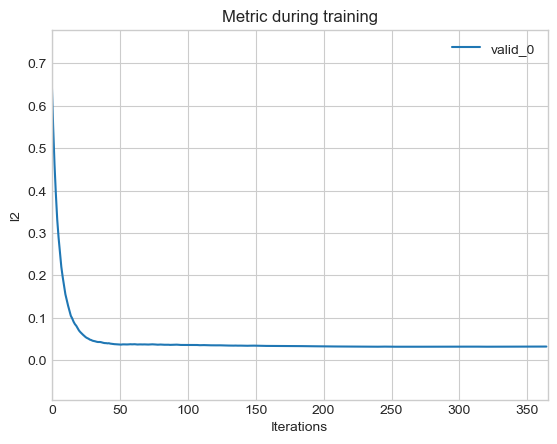

In [240]:
plot_metric(lgbmr);

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

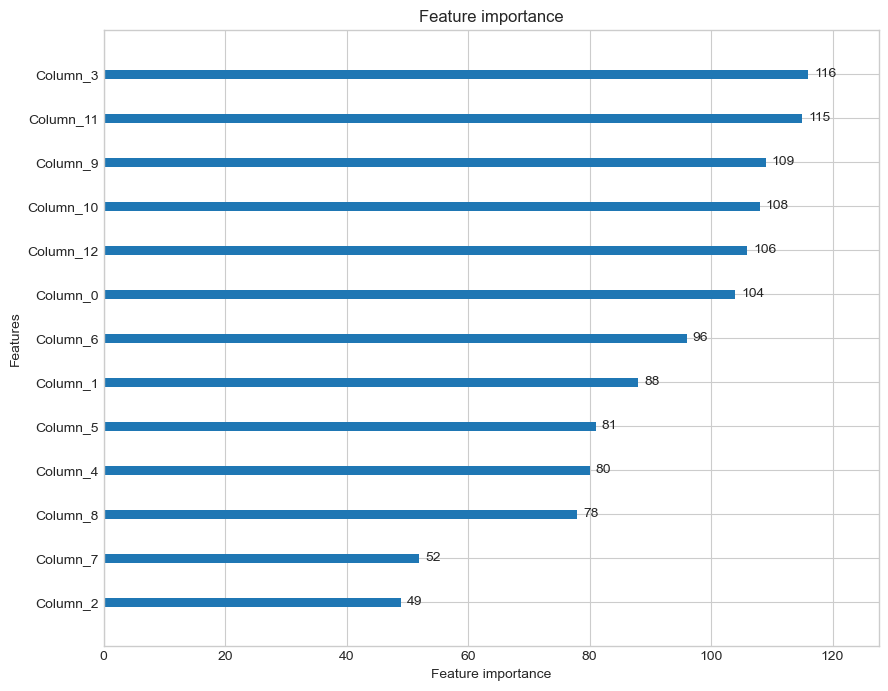

In [250]:
fig, ax = plt.subplots(figsize=(10, 8))
lgbm.plot_importance(lgbmr, ax=ax)

<AxesSubplot:>

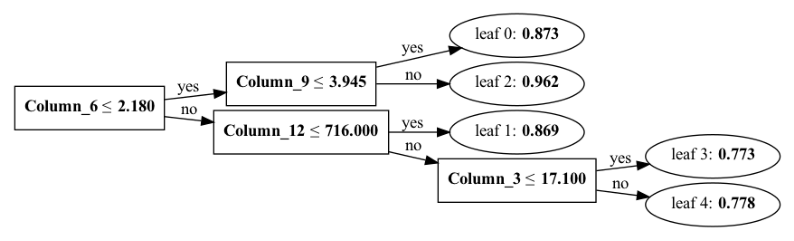

In [251]:
fig, ax = plt.subplots(figsize=(10, 8))
lgbm.plot_tree(lgbmr, ax=ax)